In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lib.dataset_utils import *
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import torch
from transformers import BertTokenizer

### Load Data

In [2]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)
label_names = train_df.columns[1:]

In [3]:
train_df.head(20)

,text,admiration,amusement,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,...,sadness,surprise,neutral,annoyance,approval,caring,confusion,curiosity,desire,disappointment
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,WHY THE FUCK IS BAYLESS ISOING,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,Yes I heard abt the f bombs! That has to be wh...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,We need more boards and to create a bit more s...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,Damn youtube and outrage drama is super lucrat...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,It might be linked to the trust factor of your...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Explore Data

In [4]:
train_df.isna().sum()

text              0
admiration        0
amusement         0
disapproval       0
disgust           0
embarrassment     0
excitement        0
fear              0
gratitude         0
grief             0
joy               0
love              0
nervousness       0
anger             0
optimism          0
pride             0
realization       0
relief            0
remorse           0
sadness           0
surprise          0
neutral           0
annoyance         0
approval          0
caring            0
confusion         0
curiosity         0
desire            0
disappointment    0
dtype: int64

No nan found

### User and Reddit tags

In [5]:
# find reddit user tags in the text
occ = train_df['text'].str.findall(r"(?: ^|\b)/?u\/\w+")
occ = [item for sublist in occ for item in sublist]
occ = pd.Series(occ)
occ.unique()

array(['u/iBiteYou', 'u/The_White_Baron', 'u/Dr', 'u/Reijka92',
       'u/HAHAAN00B', 'u/___apollo', 'u/Utkar22', 'u/tippr',
       'u/closeteverything69', 'u/Youareapooptard', 'u/Lebronlover23',
       'u/bookluvr83', 'u/Nerdinater', 'u/backwoodmenace', 'u/Mickster19',
       'u/ianamolly', 'u/chabanais', 'u/justforyouthlogic',
       'u/JusticeForShangeIa', 'u/krazyM', 'u/stumblinbear',
       'u/TheQTVain', 'u/SchnoodleDoodleDo', 'u/cumosaurusgaysex',
       'u/lilhan2', 'u/FappingPedant', 'u/back2worksoon', 'u/flight2',
       'u/Sippinthatminttea', 'u/dances', 'u/keypuncher', 'u/ibiteyou',
       'u/jellyjellyspace', 'u/beelzebambi', 'u/955bsp', 'u/hellseashell',
       'u/fart', 'u/lola_birds', 'u/skyboundIan', 'u/GarbagePailGrrrl',
       'u/DanVsStu', 'u/workingwa', 'u/JannisT', 'u/FThumb',
       'u/EightRoundsRapid', 'u/SamuelZeign', 'u/Goyteamsix',
       'u/Jakurton', 'u/MeatheadVernacular', 'u/CareeningDirigibug',
       'u/sixstringersoldier', 'u/77096', 'u/RedOnTheRail',

In [6]:
# find subreddit tags in the text
occ = train_df['text'].str.findall(r"(?: ^|\b)/?r\/\w+")
occ = [item for sublist in occ for item in sublist]
occ = pd.Series(occ)
occ.unique()

array(['r/NewTubers', 'r/hockey', 'r/trees', 'r/Judiasm', 'r/trollGC',
       'r/goodnewsforwomen', 'r/movies', 'r/Tekken', 'r/cringe', 'r/uk',
       'r/Minnesota', 'r/fireemblem', 'r/ATAAE', 'r/comedyheaven',
       'r/tworedditorsonecup', 'r/bitcoin', 'r/Bitcoin',
       'r/foursentencehorror', 'r/2healthbars', 'r/pcmasterrace',
       'r/jokes', 'r/thathappened', 'r/HelperBot_', 'r/fellowkids',
       'r/dankmemes', 'r/sarcasm', 'r/childfree', 'r/TrueReddit',
       'r/BravoRealHousewives', 'r/spacedicks', 'r/BreadTube',
       'r/LazyMan', 'r/politics', 'r/imatotalpieceofshit',
       'r/ComedyCemetery', 'r/punpatrol', 'r/The_Donald',
       'r/momforaminute', 'r/Polygrumps', 'r/showerthoughts',
       'r/uplifting', 'r/bestof', 'r/browns', 'r/sardonicast', 'r/ATBGE',
       'r/texas', 'r/medicine', 'r/maliciouscompliance',
       'r/MurderedByWords', 'r/MLS', 'r/woooosh', 'r/pragerurine',
       'r/falcons', 'r/titlegore', 'r/nextfuckinglevel', 'r/nbastreams',
       'r/braincels

In [7]:
train_df[train_df['text'].str.contains(r"(?: ^|\b)/?r\/\w+", regex=True)]['text']

206                                Ask over at r/NewTubers
300      r/hockey has no love for us! Just stay here wi...
415      second temple stood for 420 years r/trees /r/J...
567      Nooooo r/trollGC is for memes Check out r/good...
583      >"fun" is what you say when you can't give an ...
                               ...                        
42618            This should be on r/Unexpected oh wait...
42802    just a peep from /r/leagueoflegends here with ...
43117    Thank the heavens RuneScape is coming at you a...
43316       it also can be found in r/redditsmuseumoffilth
43338    No it's propaganda we because r/politics only ...
Name: text, Length: 219, dtype: object

In [8]:
# get number of records with at least one tag
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    print(f'{name}: {len(dataset[dataset["text"].str.contains(r"(?: ^|\b)/?[ur]\/\w+", regex=True)])}')

train: 274
val: 35
test: 28


Very few records have user tags and reddit tags

### Links in text

In [9]:
# find links in the text
occ = train_df['text'].str.findall(r"(?: ^|\b)https?://\S+")
occ = [item for sublist in occ for item in sublist]
occ = pd.Series(occ)
occ.unique()
print(occ)
occ = train_df['text'].str.findall(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)')
occ = [item for sublist in occ for item in sublist]
occ = pd.Series(occ)
occ.unique()
print(occ)

Series([], dtype: object)
Series([], dtype: object)


No links found

### Distribution of text and labels over the split

#### Label Balance

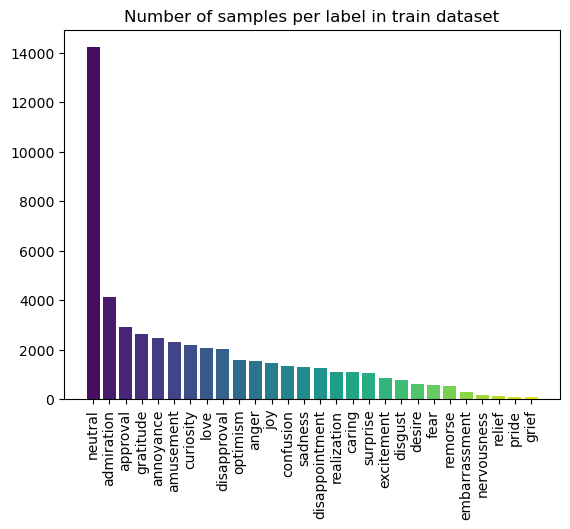

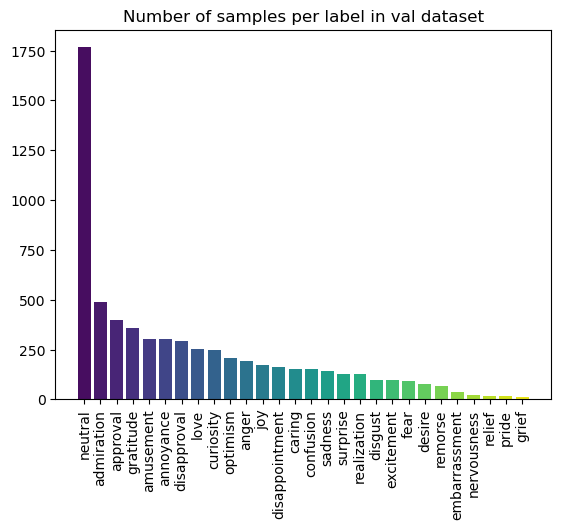

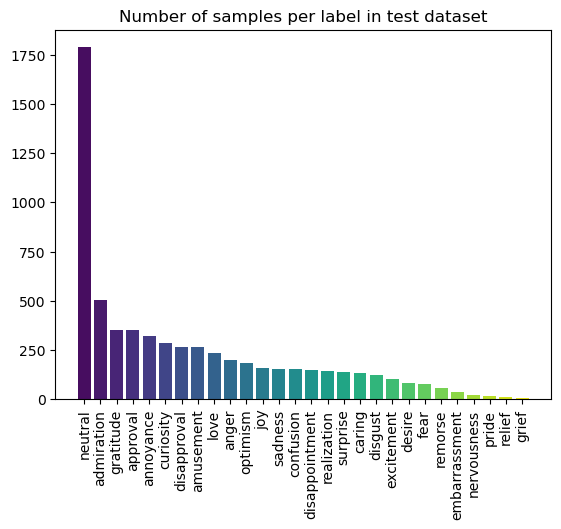

In [10]:
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    # bar plot of the number of samples per label
    dataset_labels = dataset[label_names].values
    counts = np.sum(dataset_labels, axis=0)
    # sort by counts
    sorted_idx = np.argsort(counts)[::-1]
    sorted_label_names = label_names[sorted_idx]
    counts = counts[sorted_idx]
    plt.bar(sorted_label_names, counts, color=sns.color_palette("viridis", len(sorted_label_names)))
    plt.xticks(rotation=90)
    plt.title(f'Number of samples per label in {name} dataset')
    plt.show()

### Correlation between labels

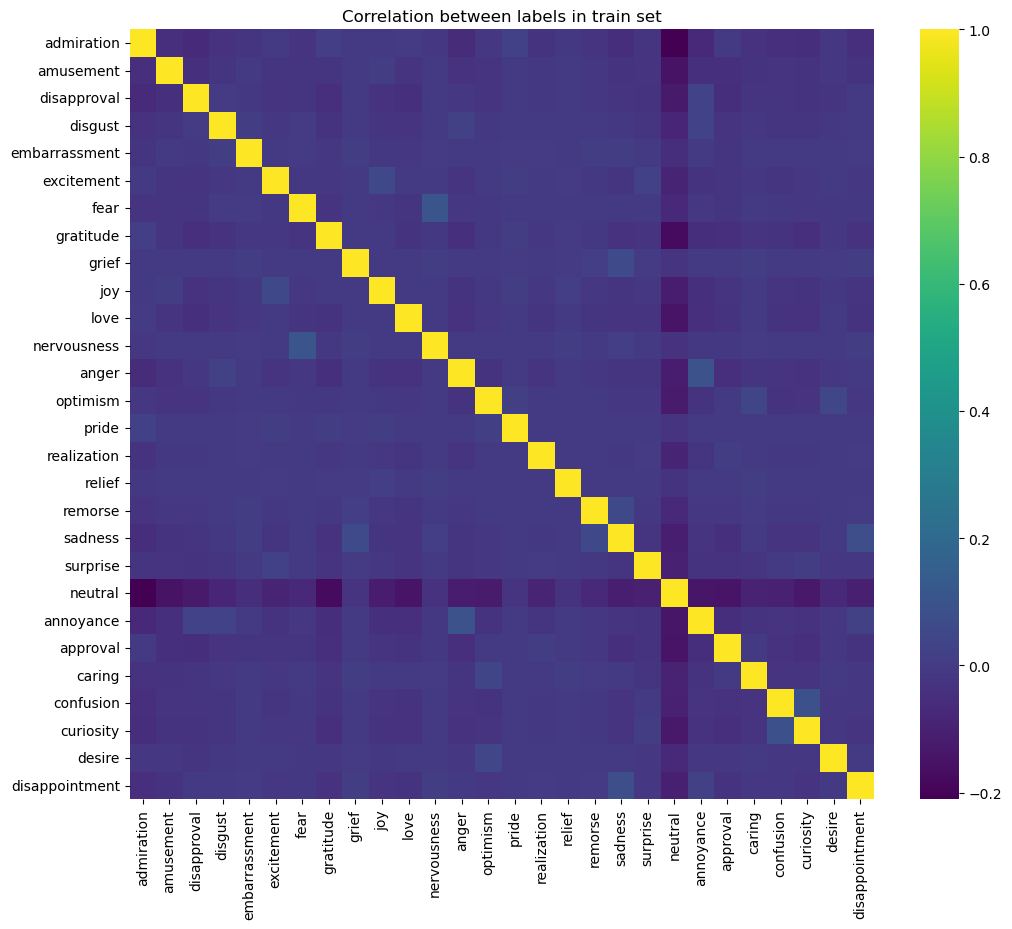

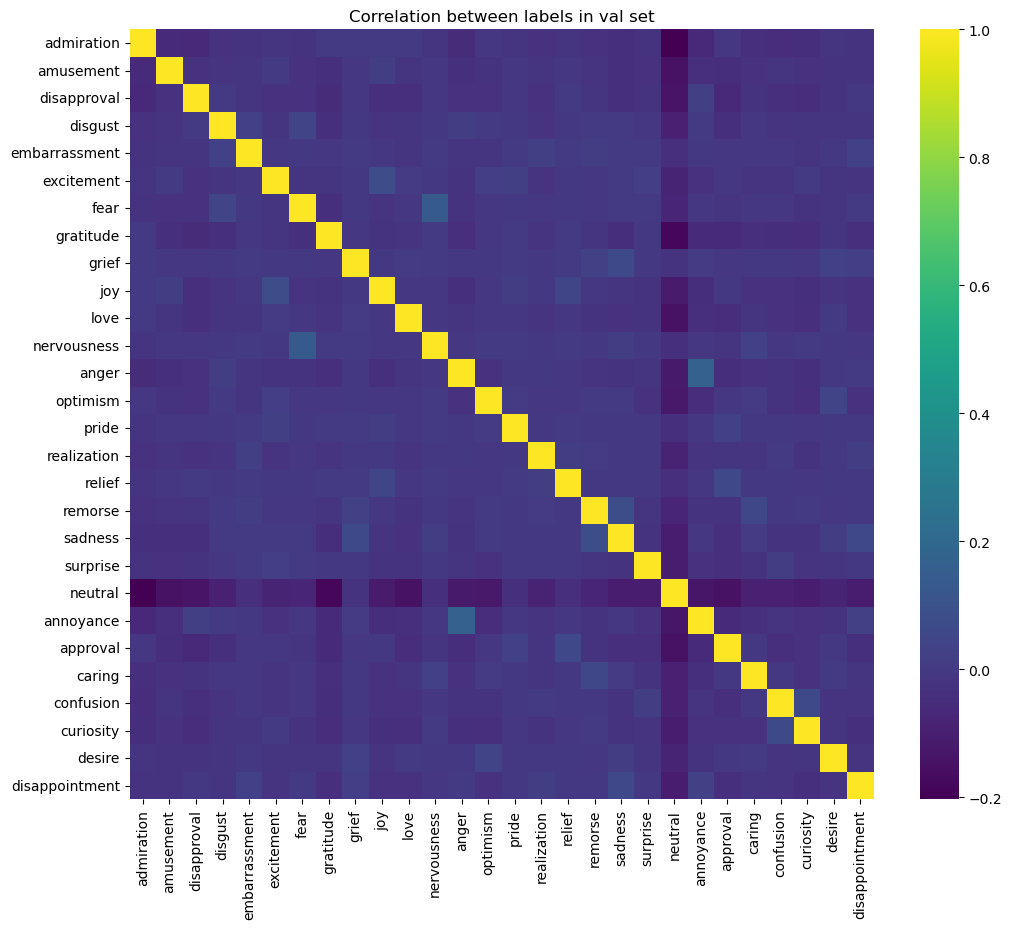

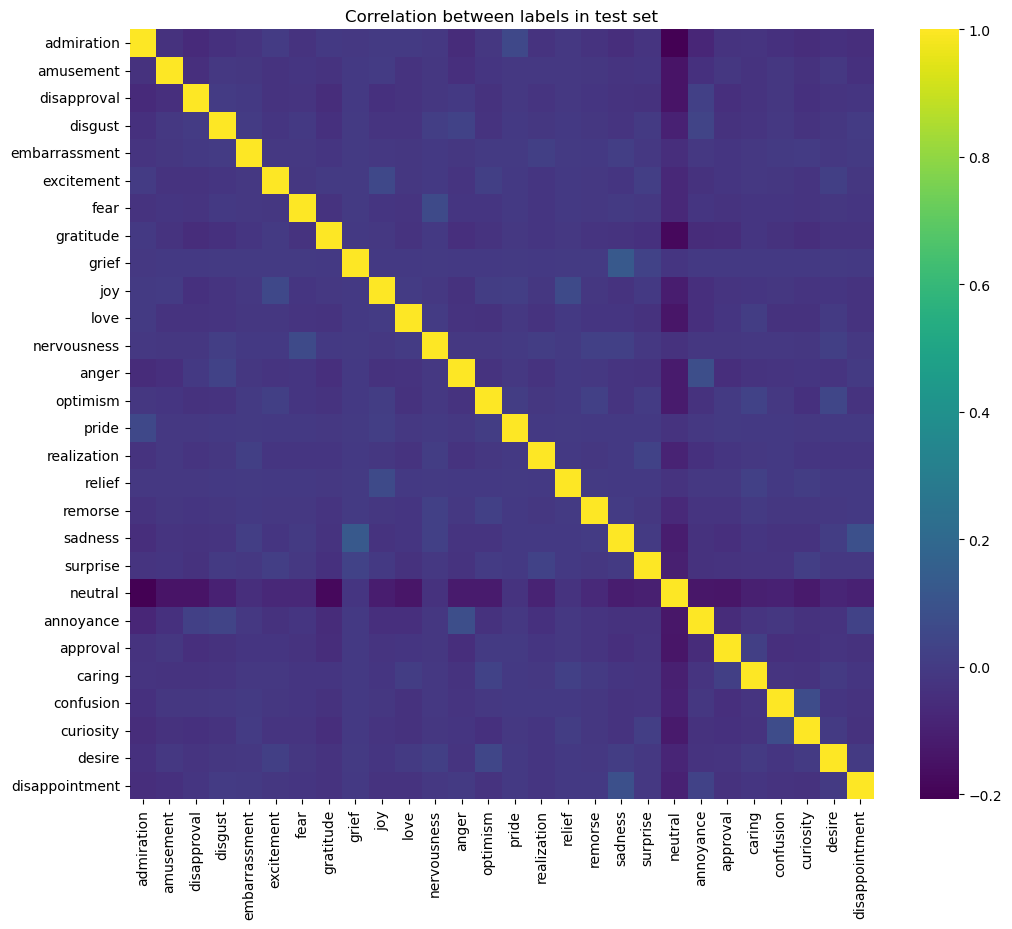

In [13]:
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    # get spearman correlation between labels
    corr = dataset[label_names].corr(method='spearman')
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=False, cmap='viridis')
    plt.title(f'Correlation between labels in {name} set')
    plt.show()

#### Text Length and word count

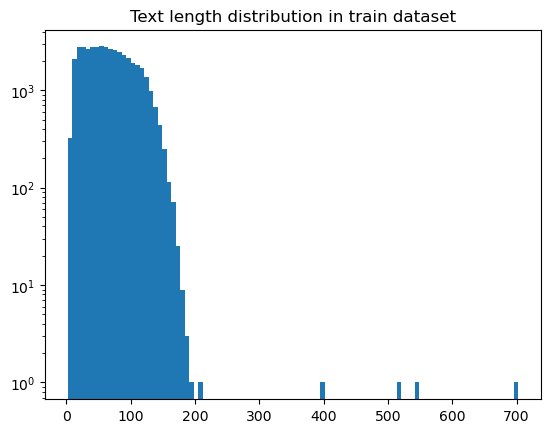

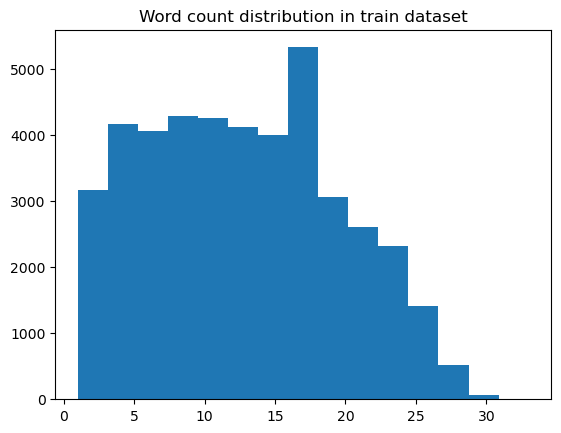

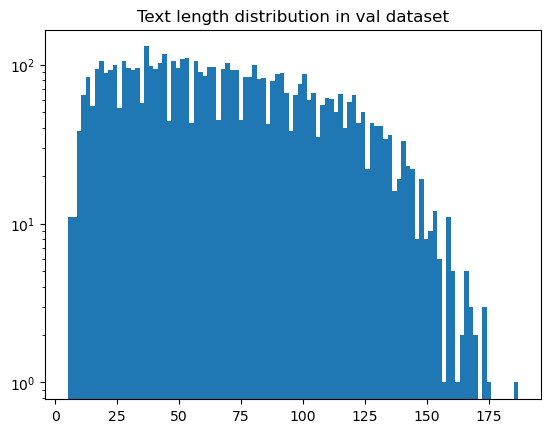

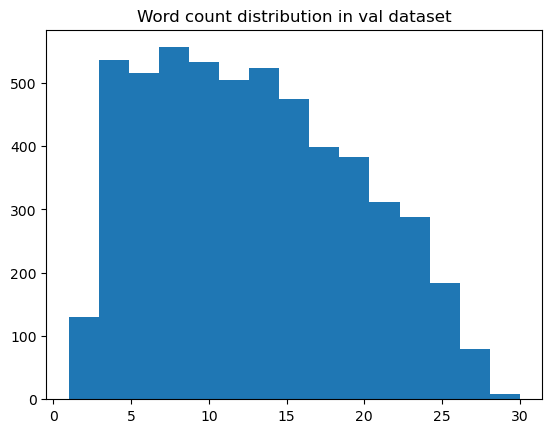

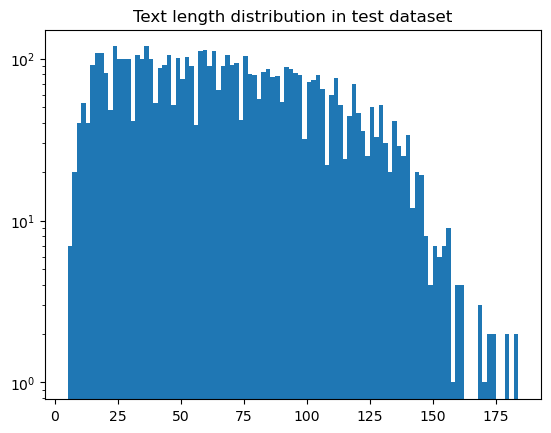

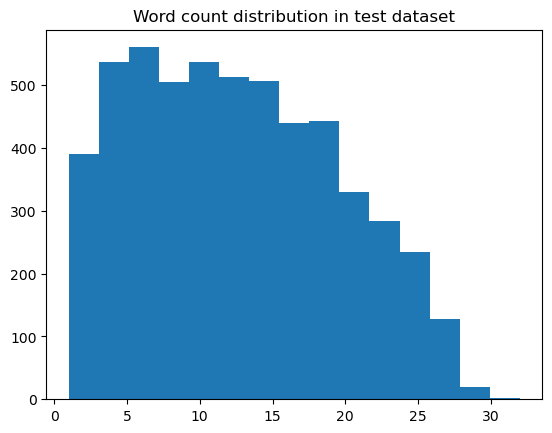

In [7]:
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    # text length histogram
    dataset['text_len'] = dataset['text'].apply(lambda x: len(x))
    dataset['text_len'].hist(bins=100)
    plt.title(f'Text length distribution in {name} dataset')
    plt.yscale('log')
    plt.grid(False)
    plt.show()
    # word count histogram
    dataset['word_count'] = dataset['text'].apply(lambda x: len(x.split()))
    dataset['word_count'].hist(bins=15)
    plt.title(f'Word count distribution in {name} dataset')
    plt.grid(False)
    plt.show()

In [12]:
train_df[train_df['text_len'] > 300]['text']

#### Text length and word count by label

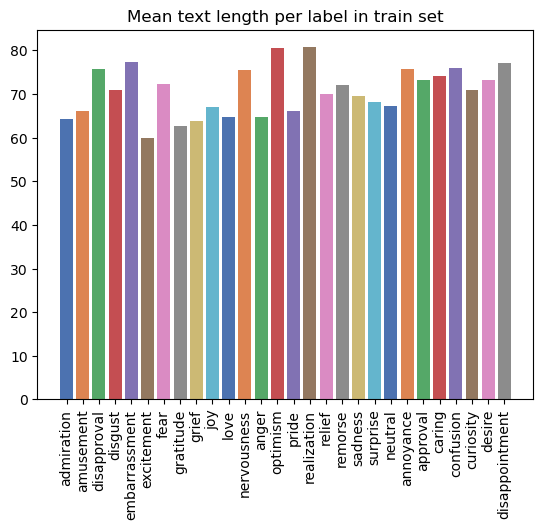

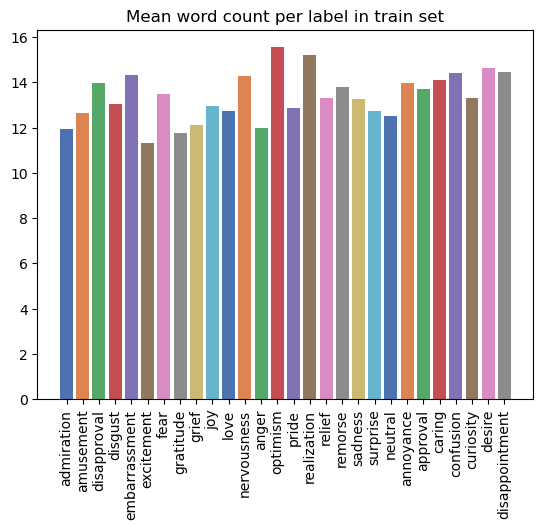

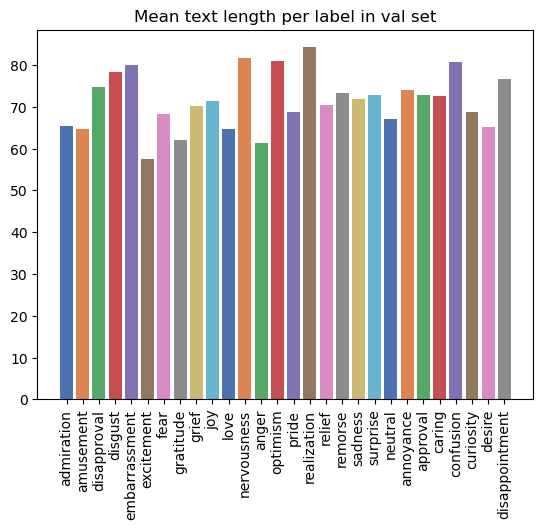

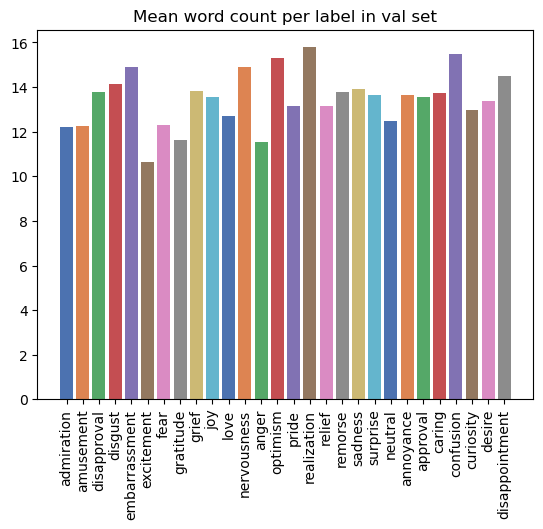

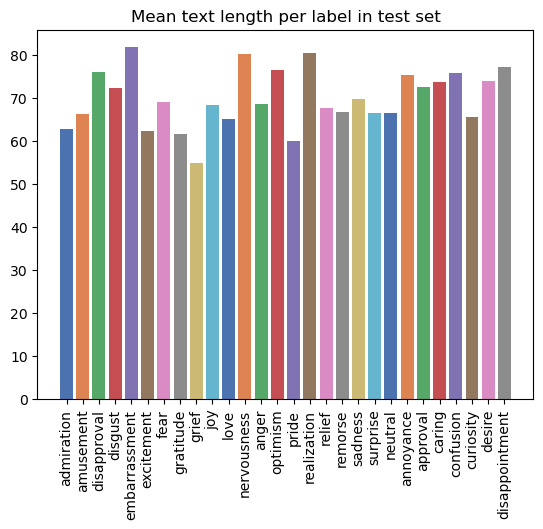

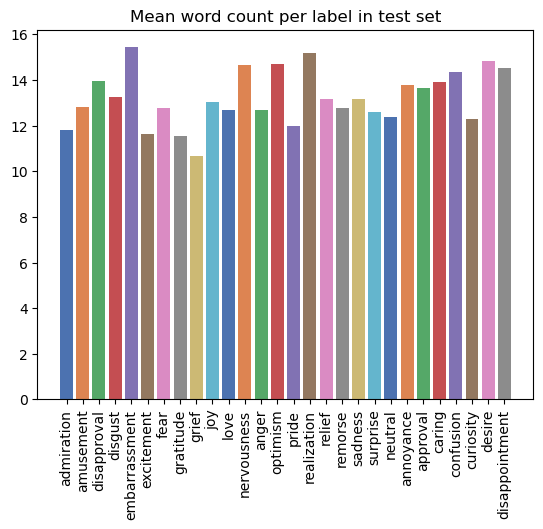

In [14]:
# mean text length per label and word count per label
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    avg_text_len = []
    avg_word_count = []
    for label in label_names:
        label_mask = dataset[label] == 1
        label_text_len = dataset[label_mask]['text_len']
        label_word_count = dataset[label_mask]['word_count']
        avg_text_len.append(np.mean(label_text_len))
        avg_word_count.append(np.mean(label_word_count))
    plt.bar(label_names, avg_text_len, color=sns.color_palette('deep', len(label_names)))
    plt.xticks(rotation=90)
    plt.title(f'Mean text length per label in {name} set')
    plt.show()
    plt.bar(label_names, avg_word_count, color=sns.color_palette('deep', len(label_names)))
    plt.xticks(rotation=90)
    plt.title(f'Mean word count per label in {name} set')
    plt.show()

## Token count

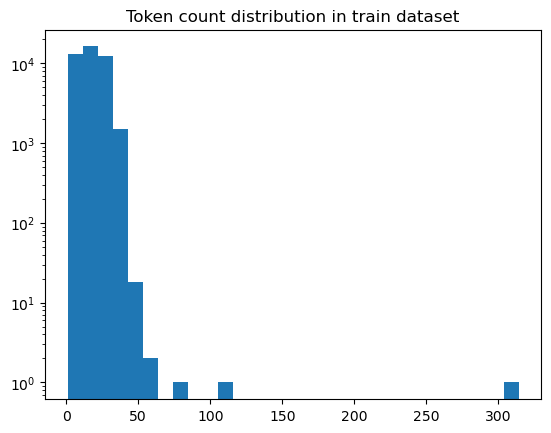

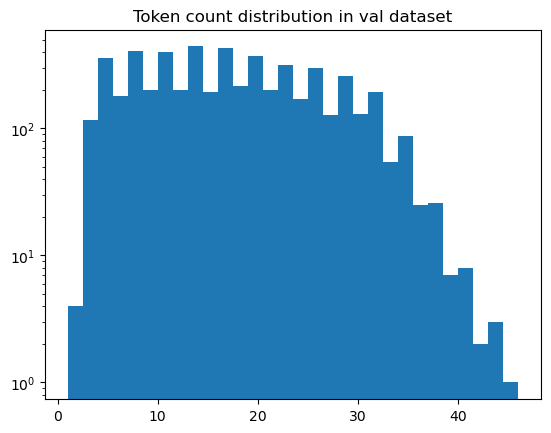

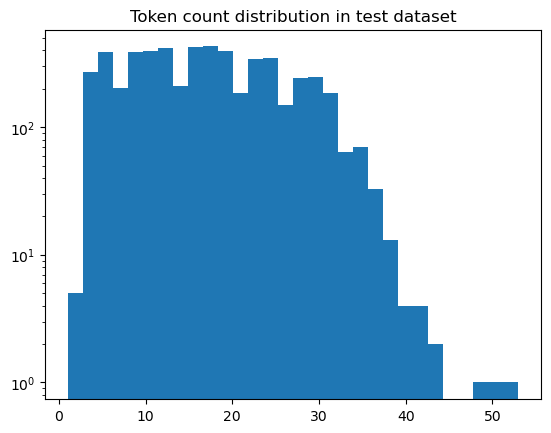

In [7]:
# count token count distribution using bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
token_counts_dict = {}
for name, dataset in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    token_counts = []
    for text in dataset['text']:
        tokens = tokenizer.tokenize(text)
        token_counts.append(len(tokens))
    plt.hist(token_counts, bins=30)
    plt.title(f'Token count distribution in {name} dataset')
    plt.grid(False)
    plt.yscale('log')
    plt.show()
    print(f'max token count in {name} dataset: {max(token_counts)}')
    token_counts_dict[name] = token_counts

In [14]:
#get sentences with high token count
occ = train_df[[el > 55 for el in token_counts_dict['train']]]
occ

,text,admiration,amusement,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,...,sadness,surprise,neutral,annoyance,approval,caring,confusion,curiosity,desire,disappointment
13412,"ackchyually, it's *r/woooosh ^^^^^I'm ^^^^^a ^...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
20785,Oh fuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26156,">It also means no applause lines. No problem, ...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
28694,here you go: |Games|Home|Away|Team|vs W-L 18-1...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Long sequences of same character

In [13]:
ids = train_df['text'].str.extract(r'(.)\1{5,}').dropna().index
train_df.loc[ids]

,text,admiration,amusement,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,...,sadness,surprise,neutral,annoyance,approval,caring,confusion,curiosity,desire,disappointment
336,"MEEEEEEEEE. Most people don't get my humour, b...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
479,What? That's exactly what I got from it. Obvio...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
653,I put cheese on everythingggggg and I ain't ev...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1403,Whaaaaaaat the heck was that?,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1418,.......... no u!,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42762,Yup. Hysterical bonding from ultimatums. Remem...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
42865,FUCK YESSSSS CJJJJJJJJ,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43034,Raptors ML $$$$$$$$$$$$ Lowry has been upgrade...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
43154,"******fucking internet, am I right?",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
